# Imports

In [1]:
%load_ext autoreload
%autoreload 2

import os

from matplotlib import pyplot as plt
import pandas as pd
import seaborn as sns
sns.set()

from tqdm.autonotebook import tqdm

import oil.utils.datetime_utils as du
import vendors.first_rate.utils as fru

%matplotlib inline

/home/julia/.conda/envs/p1_develop/lib/python3.6/site-packages/tqdm/autonotebook.py:17: TqdmExperimentalWarning: Using `tqdm.autonotebook.tqdm` in notebook mode. Use `tqdm.tqdm` instead to force console mode (e.g. in jupyter console)
  " (e.g. in jupyter console)", TqdmExperimentalWarning)


In [2]:
from pylab import rcParams
rcParams['figure.figsize'] = (20, 5)

In [3]:
import infra.helpers.telegram_notify.telegram_notify as tgn
tn = tgn.TelegramNotify()

In [4]:
def find_price_col_bug(df):
    """
    Check that column names for ['open', 'high', 'low', 'close', 'settle']
    columns correspond to one of those columns (they can be shifted)
    """
    price_cols = df.columns.intersection(
        ['open', 'high', 'low', 'close', 'settle'])
    mean_price = df[price_cols].mean()
    col_name_bug = False
    for price_col in price_cols:
        mean_other_cols = mean_price.loc[mean_price.index.drop(
            price_col)].mean()
        if not (0.98 < (mean_price.loc[price_col] / mean_other_cols) < 1.2):
            col_name_bug = True
    return col_name_bug


def verify(pq_path):
    equity = pd.read_parquet(pq_path)
    equity['timestamp'] = pd.to_datetime(equity['timestamp'], utc=True)
    summary_series = pd.Series(index=summary_cols)
    summary_series.loc['start_date'] = equity['timestamp'].iloc[0]
    summary_series.loc['end_date'] = equity['timestamp'].iloc[-1]
    summary_series.loc['n_rows'] = len(equity)
    summary_series.loc['price_col_bug'] = find_price_col_bug(equity)
    # check timestamps and missing days
    if 'timestamp' not in equity.columns:
        summary_series.loc['missing_timestamp_col'] = True
        bdays = pd.date_range(equity['timestamp'].iloc[0],
                              equity['timestamp'].iloc[-1],
                              freq=du.CBD)
        n_missing_days = len(bdays) - len(equity)
        summary_series.loc['n_missing_market_days'] = n_missing_days
    else:
        summary_series.loc['missing_timestamp_col'] = False
        bdays = pd.date_range(equity['timestamp'].iloc[0],
                              equity['timestamp'].iloc[-1],
                              freq=du.CBD,
                              tz=equity['timestamp'].iloc[0].tz)
        missing_bdays = bdays.difference(equity['timestamp'].dt.date)
        summary_series.loc['n_missing_market_days'] = len(missing_bdays)
    return summary_series

In [5]:
PQ_DIR = '/data/first_rate/pq'

# Get file list

In [6]:
pq_files = []
for category_dir in os.listdir(PQ_DIR):
    category_dir_path = os.path.join(PQ_DIR, category_dir)
    for file_name in os.listdir(category_dir_path):
        file_path = os.path.join(category_dir_path, file_name)
        pq_files.append(file_path)

In [7]:
len(pq_files)

553

# Collect a summary

In [8]:
summary_cols = [
    'start_date', 'end_date', 'n_missing_market_days', 'n_rows',
    'missing_timestamp_col', 'price_col_bug'
]

In [9]:
summary = pd.DataFrame(columns=summary_cols, index=pq_files)
summary.index.name = 'file_name'

In [10]:
%%time
for pq_path in tqdm(pq_files):
    summary_equity = verify(pq_path)
    summary.loc[pq_path] = summary_equity


CPU times: user 33min 3s, sys: 4min 23s, total: 37min 26s
Wall time: 36min 43s


In [11]:
summary.to_csv('/data/first_rate/file_summary.csv', index=0)

In [12]:
tn.notify("Collected stats for each pq")

In [20]:
tn.notify(summary.head())

# Stats

In [13]:
summary.head()

,start_date,end_date,n_missing_market_days,n_rows,missing_timestamp_col,price_col_bug
file_name,,,,,,
/data/first_rate/pq/stock_A-D/A_1HOUR_32f5ke_EST.pq,2004-01-23 14:30:00+00:00,2018-12-31 20:00:00+00:00,3764,26223,False,False
/data/first_rate/pq/stock_A-D/A_1MIN_d0tc9g_EST.pq,2004-01-23 14:30:00+00:00,2019-03-25 19:59:00+00:00,3821,1465772,False,False
/data/first_rate/pq/stock_A-D/AAP_1HOUR_i7jk9a_EST.pq,2004-01-23 14:30:00+00:00,2018-12-31 20:00:00+00:00,3764,26221,False,False
/data/first_rate/pq/stock_A-D/AAP_1MIN_jskmln_EST.pq,2004-01-23 14:35:00+00:00,2019-03-22 19:59:00+00:00,3820,1463636,False,False
/data/first_rate/pq/stock_A-D/AAPL_1HOUR_3yu77g_EST.pq,2004-01-23 14:30:00+00:00,2019-03-18 19:00:00+00:00,3816,35256,False,False


In [14]:
summary['missing_timestamp_col'].sum()

0

In [22]:
summary['price_col_bug'].sum()

0

In [16]:
summary['n_missing_market_days'] / summary['n_rows']

file_name
/data/first_rate/pq/stock_A-D/A_1HOUR_32f5ke_EST.pq                0.143538
/data/first_rate/pq/stock_A-D/A_1MIN_d0tc9g_EST.pq               0.00260682
/data/first_rate/pq/stock_A-D/AAP_1HOUR_i7jk9a_EST.pq              0.143549
/data/first_rate/pq/stock_A-D/AAP_1MIN_jskmln_EST.pq             0.00260994
/data/first_rate/pq/stock_A-D/AAPL_1HOUR_3yu77g_EST.pq             0.108237
                                                                   ...     
/data/first_rate/pq/crypto/ETH_1MIN_kv3a9v_UTC.pq               0.000696792
/data/first_rate/pq/commodity/LIGHTCMDUSD_5MIN_7wrl66_UTC.pq     0.00373628
/data/first_rate/pq/commodity/BRENTCMDUSD_5MIN_a9mgre_UTC.pq     0.00407843
/data/first_rate/pq/commodity/XAGUSD_5MIN_m7suba_UTC.pq          0.00260447
/data/first_rate/pq/commodity/XAUUSD_5MIN_bovr84_UTC.pq           0.0034949
Length: 553, dtype: object

In [21]:
summary['n_rows'].sort_values(ascending=False).head(10)

file_name
/data/first_rate/pq/stock_E-I/GE_1MIN_ftty3w_EST.pq        1500914
/data/first_rate/pq/commodity/XAGUSD_5MIN_m7suba_UTC.pq    1470164
/data/first_rate/pq/stock_J-N/JPM_1MIN_e2dh44_EST.pq       1468432
/data/first_rate/pq/stock_S-Z/WMT_1MIN_mpo52w_EST.pq       1468421
/data/first_rate/pq/stock_O-R/PG_1MIN_3duuj0_EST.pq        1468337
/data/first_rate/pq/stock_A-D/BAC_1MIN_hbth0j_EST.pq       1468329
/data/first_rate/pq/stock_S-Z/VZ_1MIN_yf06so_EST.pq        1468240
/data/first_rate/pq/stock_A-D/AMT_1MIN_tk4nve_EST.pq       1467980
/data/first_rate/pq/stock_A-D/CVX_1MIN_ezm637_EST.pq       1467962
/data/first_rate/pq/stock_S-Z/WFC_1MIN_sj69y5_EST.pq       1467860
Name: n_rows, dtype: object

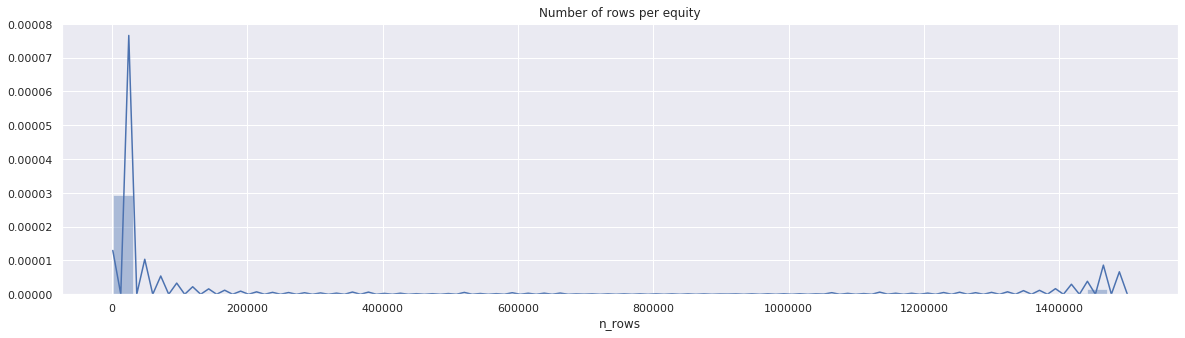

In [17]:
sns.distplot(summary['n_rows'])
plt.title('Number of rows per equity')
plt.show()

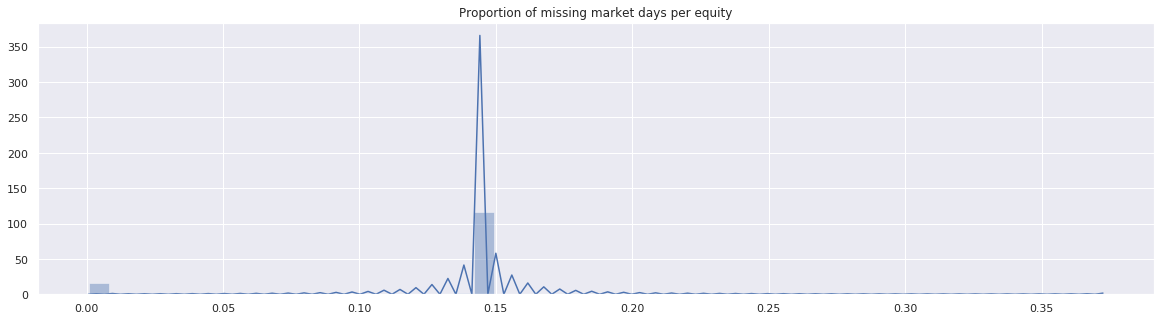

In [18]:
sns.distplot(summary['n_missing_market_days'] / summary['n_rows'])
plt.title('Proportion of missing market days per equity')
plt.show()

In [30]:
top_missing_pct = (summary['n_missing_market_days'] /
                   summary['n_rows']).sort_values(ascending=False)

In [31]:
top_missing_pct.head(20)

file_name
/data/first_rate/pq/stock_S-Z/UAL_1HOUR_jbj8rc_EST.pq     0.372452
/data/first_rate/pq/stock_E-I/EVRG_1HOUR_ym14t0_EST.pq    0.145129
/data/first_rate/pq/stock_E-I/FTV_1HOUR_jbiyhc_EST.pq      0.14511
/data/first_rate/pq/stock_A-D/BHF_1HOUR_h1ik54_EST.pq      0.14499
/data/first_rate/pq/stock_A-D/CMS_1HOUR_uqqyte_EST.pq     0.144736
/data/first_rate/pq/stock_J-N/LW_1HOUR_7c18ee_EST.pq      0.144294
/data/first_rate/pq/stock_S-Z/UA_1HOUR_5jvoaq_EST.pq       0.14427
/data/first_rate/pq/stock_S-Z/XEL_1HOUR_05pjdp_EST.pq     0.144165
/data/first_rate/pq/stock_O-R/PEP_1HOUR_20b50w_EST.pq     0.144129
/data/first_rate/pq/stock_O-R/PFG_1HOUR_jlaheu_EST.pq     0.144119
/data/first_rate/pq/stock_A-D/DWDP_1HOUR_fm6vjn_EST.pq    0.144024
/data/first_rate/pq/stock_S-Z/WRK_1HOUR_7yizls_EST.pq     0.143946
/data/first_rate/pq/stock_A-D/BHGE_1HOUR_81zaik_EST.pq    0.143893
/data/first_rate/pq/stock_S-Z/WELL_1HOUR_0ol02q_EST.pq    0.143809
/data/first_rate/pq/stock_E-I/FANG_1HOUR_j9zmap_EST.

In [34]:
summary.loc[top_missing_pct.head(20).index]

,start_date,end_date,n_missing_market_days,n_rows,missing_timestamp_col,price_col_bug
file_name,,,,,,
/data/first_rate/pq/stock_S-Z/UAL_1HOUR_jbj8rc_EST.pq,2006-02-02 14:30:00+00:00,2018-12-31 20:00:00+00:00,3253,8734,False,False
/data/first_rate/pq/stock_E-I/EVRG_1HOUR_ym14t0_EST.pq,2018-06-05 13:30:00+00:00,2018-12-31 20:00:00+00:00,146,1006,False,False
/data/first_rate/pq/stock_E-I/FTV_1HOUR_jbiyhc_EST.pq,2016-06-13 15:00:00+00:00,2018-12-31 20:00:00+00:00,644,4438,False,False
/data/first_rate/pq/stock_A-D/BHF_1HOUR_h1ik54_EST.pq,2017-07-17 13:30:00+00:00,2018-12-31 20:00:00+00:00,369,2545,False,False
/data/first_rate/pq/stock_A-D/CMS_1HOUR_uqqyte_EST.pq,2004-01-23 14:30:00+00:00,2018-12-31 20:00:00+00:00,3764,26006,False,False
/data/first_rate/pq/stock_J-N/LW_1HOUR_7c18ee_EST.pq,2016-11-01 18:00:00+00:00,2018-12-31 20:00:00+00:00,545,3777,False,False
/data/first_rate/pq/stock_S-Z/UA_1HOUR_5jvoaq_EST.pq,2016-03-23 13:30:00+00:00,2018-12-31 20:00:00+00:00,700,4852,False,False
/data/first_rate/pq/stock_S-Z/XEL_1HOUR_05pjdp_EST.pq,2018-01-02 14:30:00+00:00,2018-12-31 20:00:00+00:00,252,1748,False,False
/data/first_rate/pq/stock_O-R/PEP_1HOUR_20b50w_EST.pq,2017-12-20 14:30:00+00:00,2018-12-31 20:00:00+00:00,259,1797,False,False
